In [4]:
import os
import gc
import sys
import time
import json 
import random
import logging 
import warnings
import numpy as np
import pandas as pd 
import rasterio as rio
import scipy.io as sio
import geopandas as gpd
from ctypes import c_double
from shapely.wkt import loads
from shapely.geometry import Point
import scipy.spatial.distance
### dir
home_dir = '/home/bingyu/Documents/spatial_queue' # os.environ['HOME']+'/spatial_queue'
work_dir = '/home/bingyu/Documents/spatial_queue' # os.environ['WORK']+'/spatial_queue'
scratch_dir = '/home/bingyu/Documents/spatial_queue/projects/game/simulation_outputs' # os.environ['OUTPUT_FOLDER']
### user
sys.path.insert(0, home_dir)
import util.haversine as haversine
from model.queue_class import Network, Node, Link, Agent

import warnings
warnings.filterwarnings('error', message='Creating an ndarray from ragged*')

random_seed = 0
random.seed(random_seed)
np.random.seed(random_seed)

In [67]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)
import shapely.wkt
import shapely.ops
from shapely.geometry import Point
from shapely.wkt import loads 
from shapely.ops import substring
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import cm
import rasterio
import rasterio.plot 
from rasterio.warp import transform
from osgeo import gdal
from PIL import Image
%matplotlib inline

In [2]:
def preparation(random_seed=0, fire_id=None, comm_id=None, vphh=None, visitor_cnts=None, contra_id=None, link_closed_time=None, closed_mode=None, shelter_scen_id=None, scen_nm=None):
    ### logging and global variables

    project_location = '/projects/bolinas'
    network_file_edges = project_location + '/network_inputs/bolinas_edges_sim.csv'
    network_file_nodes = project_location + '/network_inputs/bolinas_nodes_sim.csv'
    network_file_special_nodes = project_location + '/network_inputs/bolinas_special_nodes.json'
    demand_files = [project_location + '/demand_inputs/od_csv/resident_visitor_od_rs{}_commscen{}_vphh{}_visitor{}.csv'.format(random_seed, comm_id, vphh, visitor_cnts)]
    simulation_outputs = '' ### scratch_folder
   
    if contra_id=='0': cf_files = []
    elif contra_id=='1': cf_files = [project_location + '/network_inputs/bolinas_contraflow.csv']
    else: cf_files = []

    scen_nm = scen_nm
    logging.basicConfig(filename=scratch_dir+simulation_outputs+'/log/{}.log'.format(scen_nm), filemode='w', format='%(asctime)s - %(message)s', level=logging.INFO, force=True)
    logging.info(scen_nm)
    print('log file created for {}'.format(scen_nm))

    ### network
    with open(work_dir + network_file_special_nodes) as special_nodes_file:
        special_nodes = json.load(special_nodes_file)
    network = Network()
    network.dataframe_to_network(project_location=project_location, network_file_edges = network_file_edges, network_file_nodes = network_file_nodes, cf_files = cf_files, special_nodes=special_nodes, scen_nm=scen_nm)
    network.add_connectivity()

    ### demand
    network.add_demand(demand_files = demand_files)
    logging.info('total numbers of agents taken {}'.format(len(network.agents.keys())))

    return {'network': network}, {'scen_nm': scen_nm, 'simulation_outputs': simulation_outputs, 'fire_id': fire_id, 'comm_id': comm_id, 'special_nodes': special_nodes, 'link_closed_time': link_closed_time, 'closed_mode': closed_mode, 'shelter_scen_id': shelter_scen_id}, {'in_fire_dict': {}, 'shelter_capacity_122': 200, 'shelter_capacity_202': 100}

In [6]:
fire_id='1'
comm_id='1'
vphh=2
visitor_cnts=300
contra_id='0'
shelter_scen_id='0'
link_closed_time=0
closed_mode='flame'

# preparation
scen_nm = "r{}_fire{}_comm{}_vphh{}_vistor{}_contra{}_close{}m{}_shelter{}".format(random_seed, fire_id, comm_id, vphh, visitor_cnts, contra_id, link_closed_time, closed_mode, shelter_scen_id)
data, config, update_data = preparation(random_seed=random_seed, fire_id=fire_id, comm_id=comm_id, vphh=vphh, visitor_cnts=visitor_cnts, contra_id=contra_id, shelter_scen_id=shelter_scen_id, link_closed_time=link_closed_time, closed_mode=closed_mode, scen_nm=scen_nm)

# for t in range(0, 7201):
#     network, status = dta_meso.one_step(t, data, config, update_data)

log file created for r0_fire1_comm1_vphh2_vistor300_contra0_close0mflame_shelter0
# agents from file  1490


In [29]:
def link_model(t, network, link_closed_time=None, closed_mode=None):
    
    # run link model
    for link_id, link in network.links.items(): 
        link.run_link_model(t, agent_id_dict=network.agents)

    return network

def node_model(t, network, special_nodes=None):
    # only run node model for those with vehicles waiting
    node_ids_to_run = set([link.end_nid for link in network.links.values() if len(link.queue_vehicles)>0])

    # run node model
    for node_id in node_ids_to_run:
        node = network.nodes[node_id] 
        n_t_move, transfer_links= node.run_node_model(t, node_id_dict=network.nodes, link_id_dict=network.links, agent_id_dict=network.agents, node2link_dict=network.node2link_dict, special_nodes=special_nodes)
        
    return network

def one_step(t, data, config, update_data):

    network = data['network']
    
    scen_nm, simulation_outputs, fire_id, comm_id, special_nodes, link_closed_time, closed_mode, shelter_scen_id = config['scen_nm'], config['simulation_outputs'], config['fire_id'], config['comm_id'], config['special_nodes'], config['link_closed_time'], config['closed_mode'], config['shelter_scen_id']

    in_fire_dict, shelter_capacity_122, shelter_capacity_202 = update_data['in_fire_dict'], update_data['shelter_capacity_122'], update_data['shelter_capacity_202']
    
    ### update link travel time before rerouting
    reroute_freq_dict = {'1': 300, '2': 900, '3': 1800}
    reroute_freq = reroute_freq_dict[comm_id]
    
    ### reset link congested counter
    for link in network.links.values():
        link.congested = 0
        if (t%100==0):
            link.update_travel_time_by_queue_length(network.g)

    if t==0:
        for agent_id, agent in network.agents.items():
            network.agents[agent_id].departure_time = np.random.randint(1, 100)
#     if t%120==0:
#         print(t, network.agents[0].current_link_end_nid)

    ### agent model
    t_agent_0 = time.time()
    stopped_agents_list = []
    for agent_id, agent in network.agents.items():
        ### first remove arrived vehicles
        if agent.status == 'arrive':
            network.agents_stopped[agent_id] = (agent.status, t, agent.agent_type)
            stopped_agents_list.append(agent_id)
            continue
        ### find congested vehicles: spent too long in a link
        current_link = network.links[network.node2link_dict[(agent.current_link_start_nid, agent.current_link_end_nid)]]
        if (current_link.link_type != 'v') and (agent.current_link_enter_time is not None) and (t-agent.current_link_enter_time>3600*0.5):
            current_link.congested += 1
            if (shelter_scen_id=='0'):
                if (t-agent.current_link_enter_time>3600*3):
                    agent.status = 'shelter_a1'
            elif shelter_scen_id=='1':
                pass
            else:
                pass
        ### agents need rerouting
        # initial route 
        if (t==0) or (t%reroute_freq==agent_id%reroute_freq):
            routing_status = agent.get_path(t, g=network.g)
            agent.find_next_link(node2link_dict=network.node2link_dict)
        agent.load_vehicle(t, node2link_dict=network.node2link_dict, link_id_dict=network.links)
        ### remove passively sheltered vehicles immediately, no need to wait for node model
        if agent.status in ['shelter_p', 'shelter_a1', 'shelter_park']:
            current_link.queue_vehicles = [v for v in current_link.queue_vehicles if v!=agent_id]
            current_link.run_vehicles = [v for v in current_link.run_vehicles if v!=agent_id]
            network.nodes[agent.current_link_end_nid].shelter_counts += 1
            network.agents_stopped[agent_id] = (agent.status, t, agent.agent_type)
            stopped_agents_list.append(agent_id)
    for agent_id in stopped_agents_list:
        del network.agents[agent_id]
    t_agent_1 = time.time()

    ### link model
    ### Each iteration in the link model is not time-consuming. So just keep using one process.
    t_link_0 = time.time()
    network = link_model(t, network, link_closed_time=link_closed_time, closed_mode=closed_mode)
    t_link_1 = time.time()
    
    ### node model
    t_node_0 = time.time()
    network = node_model(t, network, special_nodes=special_nodes)
    t_node_1 = time.time()
        
    # stop
    if len(network.agents)==0:
        logging.info("all agents arrive at destinations")
        return network, 'stop'
    else:
        return network, 'continue'

In [60]:
def plot_run_queue_fire(t, current_link = None, fire_id=None, comm_id=None, shelter_scen_id=None, scen_nm=None, roads_gdf=None, fire_raster=None, fire_raster_extent=None, link_stats_gdf=None):
    fig, ax = plt.subplots(1,1, figsize=(10,10))
    ### road network
    roads = roads_gdf.plot(ax=ax, lw=0.5, color='gray', alpha=0.5)
#     print(type(roads_gdf), roads_gdf.head())
    ### current position
    current_link_plot = current_link.plot(ax=ax, lw=3, color='purple', alpha=1)
#     print(type(current_link), current_link.head())
    ### flames
    if (fire_raster is not None):
        cax = fig.add_axes([0.2, 0.2, 0.6, 0.02])
        cmap = cm.get_cmap('Oranges', 5)
        cmap.set_under(color='white', alpha=100)
        flames = ax.imshow(fire_raster, extent=fire_raster_extent, cmap=cmap, vmin=0, vmax=5)
        fig.colorbar(flames, orientation='horizontal', cax=cax)
    ### queue plot
    queue_gdf = link_stats_gdf[link_stats_gdf['q']>0].copy()
    queue_gdf['geometry'] = queue_gdf.apply(lambda x: shapely.ops.substring( x['geometry'], 1-x['q']*8/(x['length']*x['lanes']), 1, normalized=True), axis=1)
    queue = queue_gdf.plot(ax=ax, lw=1, color='red')
    ### run plot
    run_gdf = link_stats_gdf[link_stats_gdf['r']>0].copy()
    run_gdf['geometry'] = run_gdf.apply(lambda x: shapely.ops.substring( x['geometry'], 0, x['r']*8/(x['length']*x['lanes']), normalized=True), axis=1)
    run = run_gdf.plot(ax=ax, lw=1, color='blue')
    (xlim_1, xlim_2) = ax.get_xlim()
    ax.set_xlim([xlim_1 + (xlim_2-xlim_1)*0.1, xlim_1 + (xlim_2-xlim_1)*0.8])
    (ylim_1, ylim_2) = ax.get_ylim()
    ax.set_ylim([ylim_1 + (ylim_2-ylim_1)*0.1, ylim_1 + (ylim_2-ylim_1)*0.6])
    shelter_text = 'no shelter'# {1: 'No sheltering', 2: 'Sheltering'}[shelter_scen_id]
    ax.text(0.6, 0.75, 'Fire location {}\nComm. scenario {}\n{}\n{:.1f} Hr'.format(fire_id, comm_id, shelter_text, t/3600), fontsize=22, transform=ax.transAxes)
#     plt.show()
#     plt.savefig('../visualization_outputs/python_map/{}_t{}.png'.format(scen_nm, t))
#     plt.close()

# base network
roads_df = pd.read_csv(home_dir + '/projects/bolinas/network_inputs/bolinas_edges_sim.csv')
roads_gdf = gpd.GeoDataFrame(roads_df, crs='epsg:4326', geometry=roads_df['geometry'].map(loads)).to_crs(26910)

# for t in range(1800, 7200, 360):
#     # link stats
#     link_stats_df = pd.read_csv('link_stats/link_stats_{}_t{}.csv'.format(scen_nm, t))
#     link_stats_gdf = roads_gdf[['eid', 'length', 'lanes', 'geometry']].merge(link_stats_df, how='right', left_on='eid', right_on='link_id')
#     # plot
#     plot_run_queue_fire(t, scen_nm=scen_nm, fire_id=fire_id, comm_id=comm_id, shelter_scen_id=shelter_scen_id, roads_gdf=roads_gdf, fire_raster=flame_raster_array, fire_raster_extent=fire_raster_extent, link_stats_gdf=link_stats_gdf)

log file created for r0_fire1_comm1_vphh2_vistor300_contra0_close0mflame_shelter0
# agents from file  1490


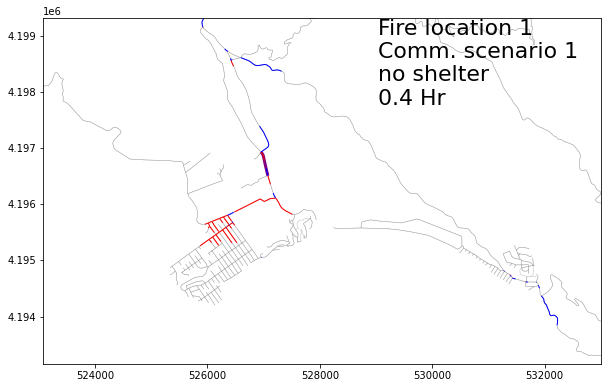

agent position at time 1600s, current link 598, next link 596, alternative next links [295, 325, 596, 597]
{295: (0, 0), 325: (0, 0), 596: (71, 15), 597: (0, 0)}
agent next link596
close 295
close 325
close 597
596 596


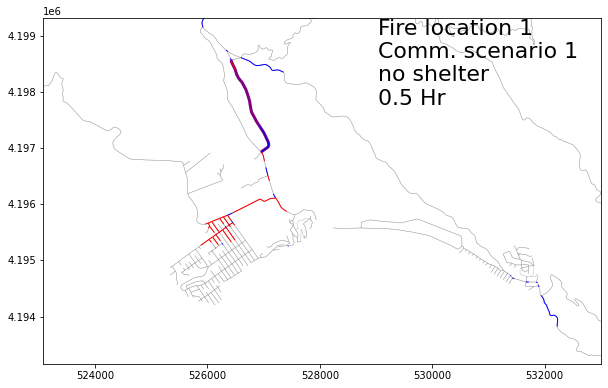

agent position at time 1650s, current link 596, next link 11, alternative next links [11, 520, 595]
{11: (2, 0), 520: (4, 0), 595: (0, 0)}
agent next link11
close 520
close 595
11 11


In [87]:
random_seed = 0
random.seed(random_seed)
np.random.seed(random_seed)

data, config, update_data = preparation(random_seed=random_seed, fire_id=fire_id, comm_id=comm_id, vphh=vphh, visitor_cnts=visitor_cnts, contra_id=contra_id, shelter_scen_id=shelter_scen_id, link_closed_time=link_closed_time, closed_mode=closed_mode, scen_nm=scen_nm)

for t in range(0, 1831):
    network, status = one_step(t, data, config, update_data)
    if t in [1600, 1650]:
        trace_agent = network.agents[0]
        current_link_id = network.node2link_dict[(trace_agent.current_link_start_nid, trace_agent.current_link_end_nid)]
        
        link_stats_df = pd.DataFrame(
            [(link.link_id, len(link.queue_vehicles), len(link.run_vehicles)) for link in network.links.values() if (link.link_type!='v') and (len(link.queue_vehicles)+len(link.run_vehicles)>0)], columns=['link_id', 'q', 'r'])
        link_stats_gdf = roads_gdf[['eid', 'length', 'lanes', 'geometry']].merge(link_stats_df, how='right', left_on='eid', right_on='link_id')
        if link_stats_gdf.shape[0]>0:
            current_link = roads_gdf.loc[roads_gdf['eid'] == current_link_id]
            plot_run_queue_fire(t, current_link=current_link, scen_nm=scen_nm, fire_id=fire_id, comm_id=comm_id, shelter_scen_id=shelter_scen_id, roads_gdf=roads_gdf, link_stats_gdf=link_stats_gdf)
            plt.show()
        
        print("agent position at time {}s, current link {}, next link {}, alternative next links {}".format(t, current_link_id, trace_agent.next_link, network.nodes[trace_agent.current_link_end_nid].outgoing_links ))
        alternative_next_links = {link_id: (len(network.links[link_id].run_vehicles), len(network.links[link_id].queue_vehicles)) for link_id in network.nodes[trace_agent.current_link_end_nid].outgoing_links}
        print(alternative_next_links)
        
        agent_next_link = input('agent next link')
        for link_id in alternative_next_links.keys():
            if str(link_id) != agent_next_link:
                print('close {}'.format(link_id))
                link = network.links[link_id]
#                 link.close_link_to_newcomers(g=network.g)
                network.g.update_edge(link.start_nid, link.end_nid, c_double(1e8))
        routing_status = network.agents[0].get_path(t, g=network.g)
        network.agents[0].find_next_link(node2link_dict=network.node2link_dict)
        print(agent_next_link, network.agents[0].next_link)
        for link_id in alternative_next_links.keys():
            if str(link_id) != agent_next_link:
                link = network.links[link_id]
#                 link.open_link_to_newcomers(g=network.g)
                network.g.update_edge(link.start_nid, link.end_nid, c_double(link.fft))
        data['network'] = network